# Group 26 Code

Link to the google drive containing the reconstructed images: https://drive.google.com/drive/folders/1FY15pVq6J7PKxyHTGX2I-N0rcisVuThg?usp=sharing

The code on this notebook loads the train data, transforms, crops and normalizes itthen applies the masks to turn it into the 4-fold and 8-fold data respectively. The code also builds a ResNet architecture which is trained on the data. 
While the network trains, the L1 Loss is printed in order to give us insight into the model's progress.After the model training is complete, the L1 Loss obtained throughout the training is plotted. The SSIM score was computed for every image before and after going through the network in order to assess the improvements made by the network.

In [1]:
#Importing all the relevant library
%matplotlib inline
import h5py, os
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
from functions import transforms as T 
from functions.subsample import MaskFunc

In [2]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [3]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]

        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

In [4]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)
    
    
    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
      

    img_gt = T.center_crop(T.complex_abs(img_gt), [320, 320])
    img_und = T.center_crop(T.complex_abs(img_und), [320, 320])
        
    return img_gt.squeeze(0), img_und.squeeze(0)


In [5]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
    
    return data_list    

# Our initial model, based on the AlexNet architecture

In [6]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64 ,64, kernel_size=3, padding=1),  # 320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 320/320
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # 320/320
            
            
        )

    def forward(self, x):
        x = self.features(x)
        return x

# Final model - the ResNet
It contains 12 residual blocks, with 2-3 convolutional layers each and batch normalisation in between the layers.The number of feature maps has been kept constant at 64 throughout the model.
The kernel-size has also been kept constant at 3, with stride and padding of 1 to maintaing the dimentionality of the images.

In [6]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
        self.layer9 = self._layer(block,64,num_layers[3],stride=1)
        self.layer10 = self._layer(block,64,num_layers[3],stride=1)
        self.layer11 = self._layer(block,64,num_layers[3],stride=1)
        self.layer12 = self._layer(block,64,num_layers[3],stride=1)
        self.conv2 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.conv2(x)

        return x

In [7]:
from skimage.measure import compare_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [10]:
if __name__ == '__main__':
    
    data_path_train = '/data/local/NC2019MRI/train'
    data_path_val = '/data/local/NC2019MRI/train'
    data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.
    
    acc = 4
    cen_fract = 0.08
    seed = False # random masks for each slice 
    num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
    lr = 1e-3
    
    network_4fold = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
    network_4fold.to('cuda:0') #move the model on the GPU
    mae_loss = nn.L1Loss().to('cuda:0')
    
    optimizer = optim.Adam(network_4fold.parameters(), lr=lr)
    fixed_train_set = []
    for val in data_list['train']:
        if val[2] > 5:
            fixed_train_set.append(val)
    #create data loader for training set. It applies same to validation set as well
    train_dataset = MRIDataset(fixed_train_set, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    
    losses=[]
    mean_loss_list = []
    img_nr = 0
    for epoch in range(1):
        for iteration, sample in enumerate(train_loader):
            img_nr += 1
            img_gt, img_und = sample
        
            img_gt = img_gt.unsqueeze(1).to('cuda:0')
            img_und = img_und.unsqueeze(1).to('cuda:0')

            output = network_4fold(img_und)       #feedforward


            loss = mae_loss(output, img_gt)

            optimizer.zero_grad()       #set current gradients to 0
            loss.backward()      #backpropagate
            optimizer.step()     #update the weights
            mean_loss_list.append(loss.item())
            #compute and print the mean L1 lossscore for the last 20 training images.
            if img_nr%20 == 0:
                print("L1 Loss score: ", np.round(np.mean(mean_loss_list), decimals = 5), "  Image number: ", img_nr, "  Epoch: ", epoch+1)
                mean_loss_list = []
            losses.append(loss.item() * img_gt.size(0))
        

L1 Loss score:  0.90973   Image number:  20   Epoch:  1
L1 Loss score:  0.12071   Image number:  40   Epoch:  1


KeyboardInterrupt: 

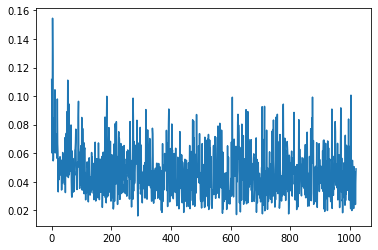

In [17]:
#L1 loss plot ofr the 4-fold data
plt.plot(losses)
plt.show()

Compute the SSIM score for every image after a feedforward propagation through the network.
Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
Print the average improvement and the average SSIM score after the reconstruction.

In [ ]:
SSIM_improvement = []
SSIM_score = []
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = network_4fold(image)
    output = output.squeeze(1).cpu().detach().numpy()
    output_loss = torch.tensor(ssim(gt, output))
    image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    SSIM_improvement.append(output_loss.item()-image_loss.item())
    SSIM_score.append(output_loss.item())

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))

In [2]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

NameError: name 'SSIM_improvement' is not defined

All the code from here on is almost the same as before, only for the 8fold data. 
The main difference is the learning rate, which is 3 times higher for the 8fold data.

In [9]:
if __name__ == '__main__':
    
    data_path_train = '/data/local/NC2019MRI/train'
    data_path_val = '/data/local/NC2019MRI/train'
    data_list = load_data_path(data_path_train, data_path_val)
    
    acc = 8
    cen_fract = 0.04
    seed = False # random masks for each slice 
    num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
    mae_loss = nn.L1Loss().to('cuda:0')
    lr = 3e-3
    
    network_8fold = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
    network_8fold.to('cuda:0') #move the model on the GPU

    
    optimizer2 = optim.Adam(network_8fold.parameters(), lr=lr)
    fixed_train_set = []
    for val in data_list['train']:
        if val[2] > 5:
            fixed_train_set.append(val)
    #create data loader for training set. It applies same to validation set as well
    train_dataset = MRIDataset(fixed_train_set, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    
    losses2=[]
    mean_loss_list = []
    img_nr = 0
    for epoch in range(3):
        for iteration, sample in enumerate(train_loader):
            img_nr += 1
            img_gt, img_und = sample
        
            img_gt = img_gt.unsqueeze(1).to('cuda:0')
            img_und = img_und.unsqueeze(1).to('cuda:0')

            output = network_8fold(img_und)       #feedforward

            loss = mae_loss(output, img_gt)

            optimizer2.zero_grad()       #set current gradients to 0
            loss.backward()      #backpropagate
            optimizer2.step()     #update the weights
            mean_loss_list.append(loss.item())
            #compute and print the mean L1 lossscore for the last 20 training images.
            if img_nr%20 == 0:
                print("L1 Loss score: ", np.round(np.mean(mean_loss_list), decimals = 5), "  Image number: ", img_nr, "  Epoch: ", epoch+1)
                mean_loss_list = []
            losses2.append(loss.item() * img_gt.size(0))
        

L1 Loss score:  1.53031   Image number:  20   Epoch:  1
L1 Loss score:  0.21   Image number:  40   Epoch:  1
L1 Loss score:  0.16881   Image number:  60   Epoch:  1


KeyboardInterrupt: 

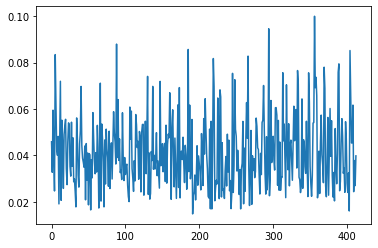

In [46]:
plt.plot(losses2)
plt.show()

In [ ]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = network_8fold(image)
    output = output.squeeze(1).cpu().detach().numpy()
    output_loss = torch.tensor(ssim(gt, output))
    image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    SSIM_improvement.append(output_loss.item()-image_loss.item())
    SSIM_score.append(output_loss.item())

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))

In [ ]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)